# Drag time

This evaluates the effect of various variables on *Drag Time*.

## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import rpy2
import math
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

%load_ext rpy2.ipython
%matplotlib inline

pen_touch_palette = sns.color_palette("colorblind", 5)
sns.set_palette(pen_touch_palette)
curvature_palette = sns.color_palette("colorblind", 6)[2:]
distance_palette = sns.color_palette("Paired")
x1fold_palette = sns.color_palette("Paired")[2:]
sns.set_style("whitegrid")
plt.rc('figure', figsize=(6.0, 4.0))

In [2]:
df_orig = pd.read_csv("../data/trials.csv")
df_orig

,participant,condition,condition_idx,prototype_idx,prototype_idx_nox1,prototype,curvature,input_type,block,task,...,trajectory_distance,time,n_attempts,task_axis_crossing,movement_direction_change,orthogonal_direction_change,movement_variability,movement_variability_hinge,movement_error,movement_offset
0,9,flat-touch,0,0,0,flat,0.0,touch,0,20,...,11.272381,1066.0,1,0,14,0,0.069686,0.069686,0.252669,0.252669
1,9,flat-touch,0,0,0,flat,0.0,touch,0,16,...,12.666076,1209.8,1,3,18,0,0.124161,0.069032,0.109941,0.106026
2,9,flat-touch,0,0,0,flat,0.0,touch,0,6,...,23.120409,1774.6,1,2,27,0,0.135713,0.088903,0.209538,0.203483
3,9,flat-touch,0,0,0,flat,0.0,touch,0,7,...,23.565728,1652.5,1,4,24,0,0.181455,0.130140,0.165829,0.065082
4,9,flat-touch,0,0,0,flat,0.0,touch,0,17,...,12.168719,1490.8,1,4,11,1,0.092684,0.054010,0.085471,-0.031356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10435,14,1mm-touch,11,5,4,1mm,1.0,touch,2,15,...,13.250031,1025.7,1,1,6,0,0.426786,0.224186,0.442196,-0.255015
10436,14,1mm-touch,11,5,4,1mm,1.0,touch,2,5,...,23.187428,1423.4,1,2,16,0,0.330995,0.031884,0.296933,-0.036865
10437,14,1mm-touch,11,5,4,1mm,1.0,touch,2,19,...,13.034942,1047.5,1,4,8,0,0.239853,0.273617,0.274385,0.255065
10438,14,1mm-touch,11,5,4,1mm,1.0,touch,2,23,...,12.726480,1177.0,1,4,8,0,0.110279,0.151618,0.101211,-0.044265


Remove flat surface used for practice

In [3]:
# Exclude the conditions on a flat surface used for practice only
df = pd.DataFrame(df_orig[df_orig["prototype_idx"] > 0])
print(len(df))

9720


## Testing for normality

In [4]:
%%R -i df

suppressPackageStartupMessages(library(car)) # leveneTest for homoscedasticity
suppressPackageStartupMessages(library(afex)) # for aov_car so we can do tukey tests
suppressPackageStartupMessages(library(emmeans)) # for emmeans pairwise contrasts (Tukey)
options(width=150) # make it easier to see huge matrices

df$participant <- factor(df$participant)
df$condition_idx <- factor(df$condition_idx)
df$prototype_idx <- factor(df$prototype_idx)
df$prototype <- factor(df$prototype)
df$curvature <- factor(df$curvature)
df$input_type <- factor(df$input_type)
df$is_long <- factor(df$is_long)
df$angle <- factor(df$angle)
df$log_time <- log(df$time)

### Normality test

In [5]:
%%R
m <- aov(log_time ~ prototype
        + Error(participant / prototype), data=df)
res <- residuals(m$`participant:prototype`)
shapiro.test(res)


	Shapiro-Wilk normality test

data:  res
W = 0.95398, p-value = 0.02406



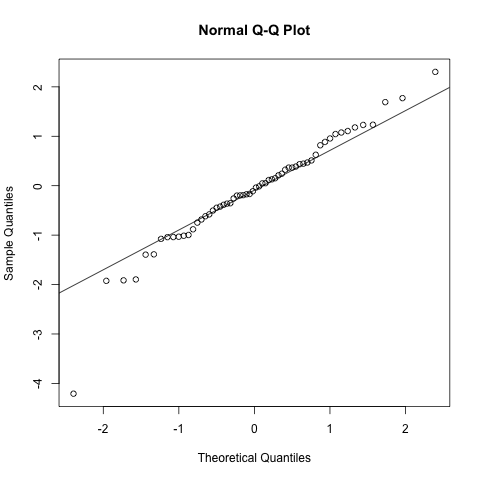

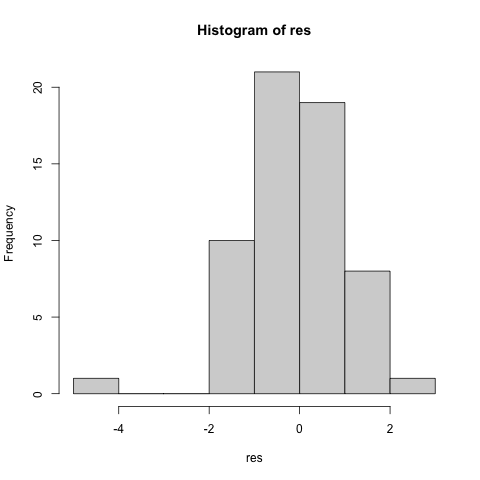

In [6]:
%%R
qqnorm(res)
qqline(res)
hist(res)

## Ordering effect

There is an ordering effect present

### Sphericity (succeeds)

In [7]:
%%R
m.order <- aov_car(log_time ~ prototype_idx + Error(participant / (prototype_idx)), df)
summary(m.order)$sphericity

              Test statistic p-value
prototype_idx        0.57382 0.65105


### ANOVA

Without GG adjustment for sphericity

In [8]:
%%R
nice(m.order, es = "pes", correction="none")

Anova Table (Type 3 tests)

Response: log_time
         Effect    df  MSE       F  pes p.value
1 prototype_idx 4, 56 0.01 4.63 ** .248    .003
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1


## Hinge Radius and Input Method

### Sphericity (succeeds)

In [9]:
%%R
df.nox1 <- subset(df, prototype != "x1fold")
df.nox1$prototype <- factor(df.nox1$prototype)

m.input <- aov_car(log_time ~ prototype * input_type + Error(participant / (prototype * input_type)), df.nox1, es = "pes")
summary(m.input)$sphericity

                     Test statistic p-value
prototype                   0.59102 0.24604
prototype:input_type        0.48602 0.10315


### ANOVA

In [10]:
%%R
# No GG correction since NS for sphericity departure
nice(m.input, correction="none", es= "pes")

Anova Table (Type 3 tests)

Response: log_time
                Effect    df  MSE      F  pes p.value
1            prototype 3, 42 0.02   2.19 .135    .103
2           input_type 1, 14 0.02 6.96 * .332    .019
3 prototype:input_type 3, 42 0.00 3.36 * .193    .028
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1


In [11]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("input_type").mean()["time"]

input_type
pen      1301.677639
touch    1211.995093
Name: time, dtype: float64

### Interaction: Hinge Radius by Input Method

The only interesting interaction is that 24mm touch to pen was significant (p = 0.0172). It had a more pronounced effect for this condition than others.

In [12]:
%%R
p.prototype.input <- emmeans(m.input, c("prototype", "input_type"))
pwpm(p.prototype.input)

            X12mm pen  X1mm pen X24mm pen  X6mm pen X12mm touch X1mm touch X24mm touch X6mm touch
X12mm pen      [7.13]    0.9780    0.7237    0.9924      0.1838     0.9918      0.0309     0.7961
X1mm pen     0.030966    [7.10]    0.9746    1.0000      0.8892     1.0000      0.0679     0.9330
X24mm pen    0.062528  0.031563    [7.06]    0.9963      0.9949     0.9293      0.0125     0.9914
X6mm pen     0.035538  0.004573 -0.026990    [7.09]      0.9623     1.0000      0.1127     0.7167
X12mm touch  0.084304  0.053339  0.021776  0.048766      [7.04]     0.8500      0.4409     1.0000
X1mm touch   0.035912  0.004946 -0.026617  0.000373   -0.048393     [7.09]      0.0067     0.7449
X24mm touch  0.172028  0.141062  0.109500  0.136490    0.087724   0.136116      [6.95]     0.7407
X6mm touch   0.098187  0.067221  0.035659  0.062649    0.013883   0.062275   -0.073841     [7.03]

Row and column labels: prototype:input_type
Upper triangle: P values   adjust = “tukey”
Diagonal: [Estimates] (emmean

### Graph

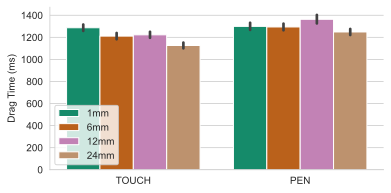

In [13]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
])
curr_df["HINGE RADIUS"] = curr_df["curvature"].apply(lambda x: f"{int(x)}mm")
curr_df["METHOD"] = curr_df["input_type"].str.upper()
curr_df = curr_df.rename({"time": "Drag Time (ms)"}, axis=1)
plt.figure(figsize=(6.0, 3.0))
ax = sns.barplot(
    data=curr_df,
    x="METHOD",
    y="Drag Time (ms)",
    hue="HINGE RADIUS",
    ci=95,
    n_boot=10000,
    palette=curvature_palette,
    hue_order=["1mm", "6mm", "12mm", "24mm"],
    order=["TOUCH", "PEN"],
)
ax.get_xaxis().get_label().set_visible(False)
ax.legend(title="", loc="lower left")
# ax.set(ylim=(0, 1500))
sns.despine(ax=ax)
plt.savefig(f"exp1-time-hinge-radius.pdf")
plt.show()

## Touch

Because pen and touch are very different input methods, we analyse them separately.

### Sphericity (fails)

Sphericity test fails, so we use GG correction

In [14]:
%%R
df.touch <- subset(df.nox1, input_type == "touch")
m.touch.angle <- aov_car(log_time ~ prototype * is_long * angle + Error(participant / (prototype * is_long * angle)), df.touch)
summary(m.touch.angle)$sphericity

                  Test statistic p-value
prototype                0.56215 0.20123
angle                    0.00000 0.00002
prototype:is_long        0.62185 0.30609
is_long:angle            0.00076 0.37754


### ANOVA

In [15]:
%%R
# Use GG correction
nice(m.touch.angle, es = "pes")

Anova Table (Type 3 tests)

Response: log_time
                   Effect          df  MSE          F  pes p.value
1               prototype 2.24, 31.37 0.42     3.64 * .207    .033
2                 is_long       1, 14 0.11 388.79 *** .965   <.001
3                   angle 4.01, 56.10 0.08  29.93 *** .681   <.001
4       prototype:is_long 2.30, 32.21 0.02       0.74 .050    .504
5         prototype:angle     33, 462 0.01    1.73 ** .110    .008
6           is_long:angle 5.69, 79.66 0.01   7.42 *** .347   <.001
7 prototype:is_long:angle     33, 462 0.00       0.80 .054    .775
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


### Hinge Radius

In [16]:
%%R
p.touch.prot <- emmeans(m.touch.angle, "prototype")
pwpm(p.touch.prot)

        X12mm    X1mm   X24mm   X6mm
X12mm  [7.04]  0.5285  0.1905 0.9942
X1mm  -0.0484  [7.09]  0.0019 0.4111
X24mm  0.0877  0.1361  [6.95] 0.4071
X6mm   0.0139  0.0623 -0.0738 [7.03]

Row and column labels: prototype
Upper triangle: P values   adjust = “tukey”
Diagonal: [Estimates] (emmean) 
Lower triangle: Comparisons (estimate)   earlier vs. later


Get the time for 1mm and 24mm

In [17]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df.groupby("prototype").mean()["time"]

prototype
12mm    1223.130093
1mm     1287.102037
24mm    1126.398148
6mm     1211.350093
Name: time, dtype: float64

### Angle

For angle below, notice how everything is the same... except for 0 degrees and 180 degrees.

In [18]:
%%R
p.touch.angle <- emmeans(m.touch.angle, "angle")
# p <- pairs(p.angle, adjust="tukey")
pwpm(p.touch.angle)

           X0      X30      X60      X90     X120     X150     X180     X210     X240     X270     X300   X330
X0     [6.84]   <.0001   <.0001   <.0001   <.0001   <.0001   0.8554   0.0001   <.0001   <.0001   <.0001 <.0001
X30  -0.23569   [7.07]   0.6018   0.9998   0.9338   0.9973   0.0002   0.7393   0.9077   1.0000   1.0000 0.6753
X60  -0.27789 -0.04220   [7.12]   0.9979   0.3647   0.7468   0.0004   0.1261   0.1457   0.5811   0.4217 0.0640
X90  -0.25333 -0.01764  0.02456   [7.09]   0.5288   0.9134   0.0011   0.6322   0.7194   0.9797   0.9955 0.6988
X120 -0.21186  0.02383  0.06602  0.04146   [7.05]   1.0000   0.0006   0.9997   1.0000   0.9703   0.9911 1.0000
X150 -0.21688  0.01880  0.06100  0.03644 -0.00502   [7.05]   0.0002   0.9997   1.0000   0.9999   1.0000 1.0000
X180 -0.02559  0.21010  0.25230  0.22774  0.18628  0.19130   [6.86]   0.0042   0.0017   0.0005   <.0001 0.0011
X210 -0.20142  0.03427  0.07647  0.05191  0.01045  0.01547 -0.17583   [7.04]   0.9997   0.6388   0.8781 1.0000
X

In [19]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("angle").mean()["time"]

angle
0.0      1002.080000
30.0     1277.712222
60.0     1337.204444
90.0     1289.405833
120.0    1224.918333
150.0    1230.267778
180.0    1018.857778
210.0    1209.597222
240.0    1216.638333
270.0    1251.809722
300.0    1257.830000
330.0    1227.619444
Name: time, dtype: float64

### Distance

In [20]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("is_long").mean()["time"]

is_long
False    1004.463194
True     1419.526991
Name: time, dtype: float64

### Interaction: Hinge Radius by Angle

In [21]:
%%R
p.touch.long.angle <- emmeans(m.touch.angle, c("prototype", "angle"))
pwpm(p.touch.long.angle, "prototype")
# contrast(p.touch.long.angle, pairwise~prototype, var="angle", interaction = "pairwise")


prototype = X12mm
            X0       X30       X60       X90      X120      X150      X180      X210      X240      X270      X300   X330
X0      [6.85]    0.0001    0.0004    <.0001    <.0001    <.0001    1.0000    <.0001    0.0007    <.0001    <.0001 0.0002
X30  -0.235023    [7.08]    0.5358    0.8964    0.9998    1.0000    0.0007    0.8024    0.8278    1.0000    1.0000 0.9844
X60  -0.290524 -0.055501    [7.14]    1.0000    0.4765    0.9173    0.0008    0.0854    0.0363    0.4617    0.8188 0.1870
X90  -0.287730 -0.052707  0.002794    [7.14]    0.1915    0.6614    0.0002    0.1060    0.0645    0.3803    0.8509 0.4308
X120 -0.217389  0.017634  0.073135  0.070341    [7.07]    0.9984    0.0010    0.9357    0.9355    1.0000    0.9849 1.0000
X150 -0.232296  0.002728  0.058228  0.055434 -0.014907    [7.08]    0.0004    0.7516    0.8886    1.0000    1.0000 0.9988
X180  0.000378  0.235401  0.290902  0.288108  0.217767  0.232674    [6.85]    0.0007    0.0031    0.0004    0.0003 0.0021
X210 

In [22]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby(["angle", "prototype"]).mean()["time"]

angle  prototype
0.0    12mm         1004.580000
       1mm          1027.923333
       24mm          942.657778
       6mm          1033.158889
30.0   12mm         1282.635556
       1mm          1370.170000
       24mm         1190.354444
       6mm          1267.688889
60.0   12mm         1371.210000
       1mm          1390.856667
       24mm         1254.568889
       6mm          1332.182222
90.0   12mm         1333.936667
       1mm          1353.502222
       24mm         1137.315556
       6mm          1332.868889
120.0  12mm         1252.164444
       1mm          1299.877778
       24mm         1124.518889
       6mm          1223.112222
150.0  12mm         1261.675556
       1mm          1308.318889
       24mm         1134.075556
       6mm          1217.001111
180.0  12mm          996.725556
       1mm          1071.201111
       24mm          973.827778
       6mm          1033.676667
210.0  12mm         1209.050000
       1mm          1303.412222
       24mm         113

### Interaction: Distance by Angle

- 0 < 120, 180 210, 240, 270, 300, 330 (0.05)
- 30 < 120, 210, 240
- 60 < 120, 210, 240, 300, 330
- 90 < 120, 210, 240
- 120 < 210, 240
- 150 < 210, 240
- 210, 240 greater than all (but that could be because these are the first tasks performed in each block).

In [23]:
%%R
p.touch.long.angle <- emmeans(m.touch.angle, c("angle", "is_long"))
# p.touch.long.angle
# contrast(p.touch.long.angle, method = list("0 30" = 0 - 90))
contrast(p.touch.long.angle, interaction = "pairwise")

 angle_pairwise is_long_pairwise  estimate     SE df t.ratio p.value
 X0 - X30       FALSE. - TRUE.    0.037745 0.0153 14   2.463  0.0274
 X0 - X60       FALSE. - TRUE.    0.065437 0.0271 14   2.415  0.0300
 X0 - X90       FALSE. - TRUE.   -0.032809 0.0180 14  -1.824  0.0896
 X0 - X120      FALSE. - TRUE.   -0.014910 0.0217 14  -0.688  0.5028
 X0 - X150      FALSE. - TRUE.   -0.001444 0.0200 14  -0.072  0.9434
 X0 - X180      FALSE. - TRUE.   -0.078049 0.0186 14  -4.197  0.0009
 X0 - X210      FALSE. - TRUE.   -0.058086 0.0189 14  -3.075  0.0082
 X0 - X240      FALSE. - TRUE.   -0.063900 0.0209 14  -3.056  0.0085
 X0 - X270      FALSE. - TRUE.   -0.057822 0.0193 14  -2.992  0.0097
 X0 - X300      FALSE. - TRUE.   -0.007541 0.0189 14  -0.400  0.6953
 X0 - X330      FALSE. - TRUE.   -0.027947 0.0232 14  -1.205  0.2480
 X30 - X60      FALSE. - TRUE.    0.027692 0.0255 14   1.087  0.2952
 X30 - X90      FALSE. - TRUE.   -0.070554 0.0257 14  -2.744  0.0158
 X30 - X120     FALSE. - TRUE.   -

In [24]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df
curr_df.reset_index(drop=True, inplace=True)
curr_df = curr_df.groupby(["angle", "is_long"]).mean()
curr_df.reset_index(drop=False, inplace=True)
long_df = curr_df[curr_df["is_long"] == True]
long_df.set_index("angle", inplace=True)
short_df = curr_df[curr_df["is_long"] == False]
short_df.set_index("angle", inplace=True)
long_df["time"].subtract(short_df["time"])

angle
0.0      362.137778
30.0     506.100000
60.0     575.032222
90.0     421.577222
120.0    419.747778
150.0    445.560000
180.0    292.152222
210.0    365.805556
240.0    361.167778
270.0    371.663889
300.0    450.124444
330.0    409.696667
Name: time, dtype: float64

### Graph

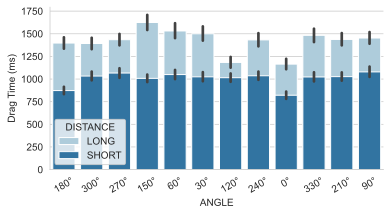

In [25]:
curr_df = pd.DataFrame(df[
    (~df["prototype"].isin(["flat", "x1fold"]))
    & (df["input_type"] == "touch")
])
curr_df = curr_df.rename({"time": "Drag Time (ms)"}, axis=1)
curr_df["DISTANCE"] = curr_df["is_long"].apply(lambda x: "LONG" if x else "SHORT")
curr_df["ANGLE"] = curr_df["angle"].apply(lambda x: f"{int(x)}°")
fig = plt.figure(figsize=(6.0, 3.0))
ax = fig.add_subplot()
for i, dist in enumerate(["LONG", "SHORT"]):
    curr = curr_df[curr_df["DISTANCE"] == dist]
    sns.barplot(
        data=curr,
        x="ANGLE",
        y="Drag Time (ms)",
        hue="DISTANCE",
        ci=95,
        n_boot=10000,
        palette=[distance_palette[i]],
        ax=ax,
        # alpha=0.5,
    )
ax.legend(title="DISTANCE", loc="lower left")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
sns.despine(ax=ax)
plt.savefig(f"exp1-time-touch-angle.pdf")
plt.show()

## Pen

### Sphericity (fails)

Sphericity test fails, so we use GG correction

In [26]:
%%R
df.pen <- subset(df.nox1, input_type == "pen")
m.pen.angle <- aov_car(log_time ~ prototype * is_long * angle + Error(participant / (prototype * is_long * angle)), df.pen)
summary(m.pen.angle)$sphericity

                  Test statistic p-value
prototype                0.80499 0.73920
angle                    0.00002 0.00210
prototype:is_long        0.43273 0.06092
is_long:angle            0.00001 0.00078


### ANOVA

In [27]:
%%R
# Use GG correction
nice(m.pen.angle, es = "pes")

Anova Table (Type 3 tests)

Response: log_time
                   Effect          df  MSE          F  pes p.value
1               prototype 2.63, 36.80 0.30       0.91 .061    .434
2                 is_long       1, 14 0.11 379.37 *** .964   <.001
3                   angle 4.96, 69.45 0.06  30.37 *** .684   <.001
4       prototype:is_long 2.17, 30.35 0.04       1.21 .080    .314
5         prototype:angle     33, 462 0.01     1.44 + .093    .056
6           is_long:angle 4.85, 67.90 0.02     2.69 * .161    .029
7 prototype:is_long:angle     33, 462 0.01       1.07 .071    .373
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


### Angle

For angle below, notice how everything is the same... except for 0 degrees and 180 degrees.

In [28]:
%%R
p.pen.angle <- emmeans(m.pen.angle, "angle")
# p <- pairs(p.angle, adjust="tukey")
pwpm(p.pen.angle)

            X0       X30       X60       X90      X120      X150      X180      X210      X240      X270      X300   X330
X0      [6.92]    0.0001    <.0001    <.0001    <.0001    0.0001    0.9864    0.0002    <.0001    <.0001    <.0001 <.0001
X30  -0.213106    [7.13]    0.4864    1.0000    1.0000    1.0000    0.0002    0.9992    0.8495    0.8980    1.0000 1.0000
X60  -0.262683 -0.049577    [7.18]    0.2108    0.8192    0.7566    <.0001    0.1606    0.0481    0.0132    0.2996 0.5410
X90  -0.208364  0.004742  0.054319    [7.12]    1.0000    1.0000    <.0001    1.0000    0.9987    0.9860    1.0000 1.0000
X120 -0.218208 -0.005102  0.044475 -0.009844    [7.13]    1.0000    <.0001    0.9976    0.9201    0.9515    1.0000 1.0000
X150 -0.220723 -0.007616  0.041961 -0.012358 -0.002515    [7.14]    <.0001    0.9951    0.9430    0.9452    1.0000 1.0000
X180 -0.018794  0.194312  0.243890  0.189570  0.199414  0.201929    [6.93]    0.0003    0.0004    0.0009    <.0001 <.0001
X210 -0.201553  0.011553

#### Get time for angles

In [29]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "pen")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("angle").mean()["time"]

angle
0.0      1079.849444
30.0     1365.573889
60.0     1412.241111
90.0     1332.145833
120.0    1357.310278
150.0    1350.931944
180.0    1113.545278
210.0    1330.505833
240.0    1308.292500
270.0    1295.171111
300.0    1333.222222
330.0    1341.342222
Name: time, dtype: float64

### Distance

In [30]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "pen")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("is_long").mean()["time"]

is_long
False    1077.785093
True     1525.570185
Name: time, dtype: float64

### Interaction: Distance by Angle

- 0, 30, 60, 90, 150, 180, 270, 330 < 210, 240
- 120, 300 < 240

In [31]:
%%R
p.pen.long.angle <- emmeans(m.pen.angle, c("is_long", "angle"))
contrast(p.pen.long.angle, interaction = "pairwise")

 is_long_pairwise angle_pairwise estimate     SE df t.ratio p.value
 FALSE. - TRUE.   X0 - X30        0.06784 0.0224 14   3.031  0.0090
 FALSE. - TRUE.   X0 - X60        0.07326 0.0162 14   4.522  0.0005
 FALSE. - TRUE.   X0 - X90        0.03185 0.0251 14   1.268  0.2253
 FALSE. - TRUE.   X0 - X120       0.05020 0.0231 14   2.175  0.0473
 FALSE. - TRUE.   X0 - X150       0.01998 0.0304 14   0.658  0.5212
 FALSE. - TRUE.   X0 - X180       0.00698 0.0323 14   0.216  0.8319
 FALSE. - TRUE.   X0 - X210      -0.00346 0.0299 14  -0.116  0.9093
 FALSE. - TRUE.   X0 - X240       0.00199 0.0284 14   0.070  0.9453
 FALSE. - TRUE.   X0 - X270       0.01776 0.0175 14   1.017  0.3263
 FALSE. - TRUE.   X0 - X300       0.02786 0.0191 14   1.461  0.1660
 FALSE. - TRUE.   X0 - X330       0.01379 0.0202 14   0.683  0.5056
 FALSE. - TRUE.   X30 - X60       0.00542 0.0190 14   0.285  0.7796
 FALSE. - TRUE.   X30 - X90      -0.03599 0.0203 14  -1.771  0.0984
 FALSE. - TRUE.   X30 - X120     -0.01764 0.0150

In [32]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "pen")
])
curr_df
curr_df.reset_index(drop=True, inplace=True)
curr_df = curr_df.groupby(["angle", "is_long"]).mean()
curr_df.reset_index(drop=False, inplace=True)
long_df = curr_df[curr_df["is_long"] == True]
long_df.set_index("angle", inplace=True)
short_df = curr_df[curr_df["is_long"] == False]
short_df.set_index("angle", inplace=True)
long_df["time"].subtract(short_df["time"])

angle
0.0      351.821111
30.0     521.100000
60.0     530.966667
90.0     465.163889
120.0    516.009444
150.0    459.800556
180.0    354.687222
210.0    406.996111
240.0    416.139444
270.0    438.610000
300.0    470.967778
330.0    441.158889
Name: time, dtype: float64

### Graph

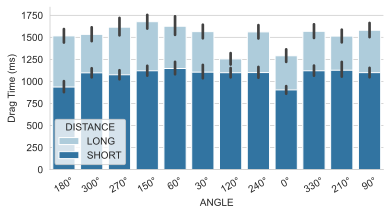

In [33]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "pen")
])
curr_df = curr_df.rename({"time": "Drag Time (ms)"}, axis=1)
curr_df["DISTANCE"] = curr_df["is_long"].apply(lambda x: "LONG" if x else "SHORT")
curr_df["ANGLE"] = curr_df["angle"].apply(lambda x: f"{int(x)}°")
fig = plt.figure(figsize=(6.0, 3.0))
ax = fig.add_subplot()
for i, dist in enumerate(["LONG", "SHORT"]):
    curr = curr_df[curr_df["DISTANCE"] == dist]
    sns.barplot(
        data=curr,
        x="ANGLE",
        y="Drag Time (ms)",
        hue="DISTANCE",
        ci=95,
        n_boot=10000,
        palette=[distance_palette[i]],
        ax=ax,
        # alpha=0.5,
    )
ax.legend(title="DISTANCE", loc="lower left")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
sns.despine(ax=ax)
plt.savefig(f"exp1-time-pen-angle.pdf")
plt.show()

## Comparing X1 Fold and 12mm

These two devices should be very similar. This is done to evaluate the external validity of the experiment.

In [34]:
%%R
df.x1fold <- subset(df, (prototype == "x1fold" | prototype == "12mm") & is_long == FALSE)
df.x1fold$prototype <- factor(df.x1fold$prototype)
m.x1fold <- aov_car(log_time ~ prototype * input_type + Error(participant / (prototype * input_type)), df.x1fold, es = "pes")
nice(m.x1fold, es = "pes")

Anova Table (Type 3 tests)

Response: log_time
                Effect    df  MSE        F   pes p.value
1            prototype 1, 14 0.01     0.02  .001    .892
2           input_type 1, 14 0.01     0.01 <.001    .921
3 prototype:input_type 1, 14 0.01 13.48 **  .491    .003
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1


### Interaction: Hinge Radius by Input Method

In [35]:
%%R
p.x1fold.prototype.input <- emmeans(m.x1fold, c("prototype", "input_type"))
pwpm(p.x1fold.prototype.input)

             X12mm pen x1fold pen X12mm touch x1fold touch
X12mm pen       [6.96]     0.1103      0.0305       0.9978
x1fold pen     0.08982     [6.87]      1.0000       0.1736
X12mm touch    0.09125    0.00143      [6.87]       0.1403
x1fold touch  -0.00692   -0.09674    -0.09817       [6.97]

Row and column labels: prototype:input_type
Upper triangle: P values   adjust = “tukey”
Diagonal: [Estimates] (emmean) 
Lower triangle: Comparisons (estimate)   earlier vs. later
